In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras import callbacks
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from keras.losses import MeanSquaredLogarithmicError
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
# Read the dataset
filename = "http://www.i3s.unice.fr/~riveill/dataset/precipitation.csv.zip"
rainfall_data_df = pd.read_csv(filename, sep="\t", engine="python", on_bad_lines="skip")
rainfall_data_df.set_index('Year', inplace=True)
rainfall_data_df.sample(n=8)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1971,0.000,0.000,0.000,0.812,57.691,297.187,122.195,372.693,286.056,39.424,0.554,0.000
1989,0.008,0.000,9.619,20.774,20.176,425.984,484.451,177.257,236.803,23.424,0.585,0.943
1986,0.000,1.229,0.000,4.567,22.547,635.977,202.570,247.395,105.095,3.746,7.457,37.386
1975,0.333,0.585,0.000,0.061,30.651,359.369,474.143,404.372,400.001,105.560,2.763,0.000
2001,0.147,0.000,2.178,1.528,7.860,247.982,279.547,189.404,158.025,135.518,23.633,0.003
1987,3.013,8.410,1.367,3.864,80.539,200.950,172.864,477.113,44.574,150.179,18.281,36.845
1992,0.000,0.000,0.000,3.165,9.580,227.180,321.551,428.764,287.582,40.079,5.982,0.000
1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685


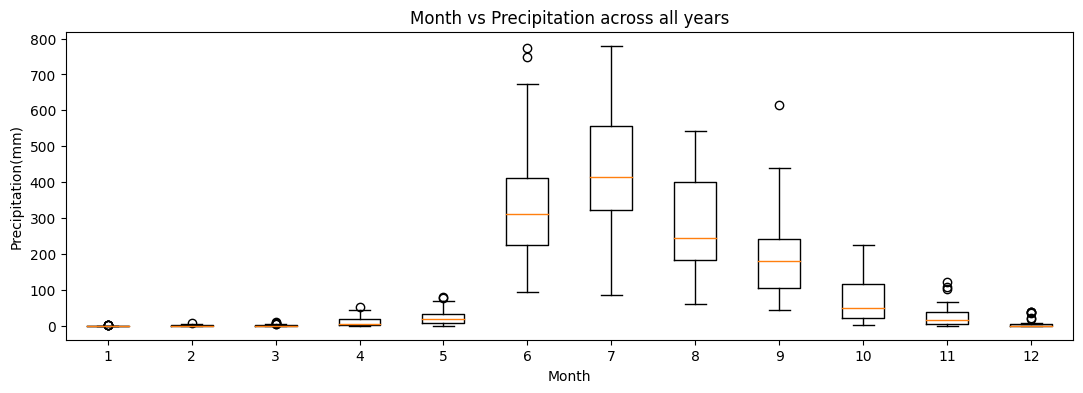

In [ ]:
#distribution of precipitations across different months
plt.figure(figsize=(13, 4))
plt.boxplot(rainfall_data_df)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')
plt.show();

In [ ]:
#transforming the data to one dimensionnal array
data = rainfall_data_df.to_numpy().ravel()
data, rainfall_data_df.shape

(array([2.90000e-02, 6.90000e-02, 0.00000e+00, 2.16670e+01, 1.78590e+01,
        1.02111e+02, 6.06071e+02, 4.02521e+02, 6.95110e+01, 5.24900e+00,
        1.62320e+01, 2.20750e+01, 9.05000e-01, 0.00000e+00, 0.00000e+00,
        2.98100e+00, 6.30080e+01, 9.40880e+01, 4.81942e+02, 5.93860e+01,
        1.50624e+02, 1.30800e+00, 4.12140e+01, 4.13200e+00, 2.48000e-01,
        3.39000e+00, 1.32000e+00, 1.34820e+01, 1.11160e+01, 2.51314e+02,
        7.80006e+02, 1.81069e+02, 1.83757e+02, 5.04040e+01, 8.39300e+00,
        3.76850e+01, 3.18000e-01, 3.03500e+00, 1.70400e+00, 2.33070e+01,
        7.44100e+00, 1.79872e+02, 3.79354e+02, 1.71979e+02, 2.19884e+02,
        7.39970e+01, 2.33260e+01, 2.02000e+00, 2.48000e-01, 2.52400e+00,
        3.34000e-01, 4.56900e+00, 6.21300e+00, 3.93682e+02, 6.78354e+02,
        3.97335e+02, 2.05413e+02, 2.40140e+01, 2.43850e+01, 1.95100e+00,
        7.00000e-02, 0.00000e+00, 1.00000e-03, 1.62180e+01, 6.80360e+01,
        3.00546e+02, 3.30502e+02, 2.83476e+02, 1.58

In [ ]:
input_width = 24
offset = 0
X = np.array([data[i:i+input_width] for i in range(len(data) - input_width)]) #we are goin to process 24 values per 24 values
y = np.array([data[i+input_width+offset] for i in range(len(data) - input_width)])
print(X)
print(y)
X.shape, y.shape

[[2.90000e-02 6.90000e-02 0.00000e+00 ... 1.30800e+00 4.12140e+01
  4.13200e+00]
 [6.90000e-02 0.00000e+00 2.16670e+01 ... 4.12140e+01 4.13200e+00
  2.48000e-01]
 [0.00000e+00 2.16670e+01 1.78590e+01 ... 4.13200e+00 2.48000e-01
  3.39000e+00]
 ...
 [3.82460e+01 1.52740e+01 8.18700e+00 ... 8.49360e+01 2.57205e+02
  7.82690e+01]
 [1.52740e+01 8.18700e+00 1.47000e-01 ... 2.57205e+02 7.82690e+01
  2.14860e+01]
 [8.18700e+00 1.47000e-01 0.00000e+00 ... 7.82690e+01 2.14860e+01
  6.14000e-01]]
[2.48000e-01 3.39000e+00 1.32000e+00 1.34820e+01 1.11160e+01 2.51314e+02
 7.80006e+02 1.81069e+02 1.83757e+02 5.04040e+01 8.39300e+00 3.76850e+01
 3.18000e-01 3.03500e+00 1.70400e+00 2.33070e+01 7.44100e+00 1.79872e+02
 3.79354e+02 1.71979e+02 2.19884e+02 7.39970e+01 2.33260e+01 2.02000e+00
 2.48000e-01 2.52400e+00 3.34000e-01 4.56900e+00 6.21300e+00 3.93682e+02
 6.78354e+02 3.97335e+02 2.05413e+02 2.40140e+01 2.43850e+01 1.95100e+00
 7.00000e-02 0.00000e+00 1.00000e-03 1.62180e+01 6.80360e+01 3.00546e+

((432, 24), (432,))

In [ ]:
#StandardScaler scales the input features to have zero mean and unit variance.
#This ensures that all input features contribute equally to the model training.
# LSTM often perform better when input features are on a similar scale.
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized= X_normalized.reshape(len(X), input_width,1)
X_normalized

array([[[-0.67149104],
        [-0.67126467],
        [-0.67165774],
        ...,
        [-0.66939227],
        [-0.43953503],
        [-0.6527399 ]],

       [[-0.6712624 ],
        [-0.67165906],
        [-0.54781133],
        ...,
        [-0.43919319],
        [-0.65347902],
        [-0.67514182]],

       [[-0.6716568 ],
        [-0.54781258],
        [-0.56957748],
        ...,
        [-0.65310194],
        [-0.6758877 ],
        [-0.65701957]],

       ...,

       [[-0.45304657],
        [-0.58435435],
        [-0.62486166],
        ...,
        [-0.18698138],
        [ 0.8066215 ],
        [-0.22513668]],

       [[-0.58435218],
        [-0.62486296],
        [-0.6708175 ],
        ...,
        [ 0.80675806],
        [-0.22574682],
        [-0.55264648]],

       [[-0.62486074],
        [-0.67081883],
        [-0.67165774],
        ...,
        [-0.22544019],
        [-0.5533554 ],
        [-0.67303083]]])

In [ ]:
# Get the number of input features by accessing the shape of the normalized input data along the second axis.
n_in = X_normalized.shape[1]
print(n_in)

# Get the number of time steps or sequence length by accessing the shape of the normalized input data along the third axis.
nb_features = X_normalized.shape[2]
print(nb_features)

# Set the number of output units to 1.
n_out = 1

# Define the input layer with shape (n_in, nb_features) for the LSTM model.
inputs = keras.layers.Input(shape=(n_in, nb_features))

# Create an LSTM layer with 64 units and set return_sequences to False since we only want the final output.
rec_layer = keras.layers.LSTM(64, return_sequences=False)(inputs)

# Create a dense layer with 1 unit and no activation function.
outputs = keras.layers.Dense(1, activation=None)(rec_layer)

# Create a Keras model with the defined input and output layers.
model = keras.Model(inputs=inputs, outputs=outputs)

# Display a summary of the model architecture.
model.summary()


24
1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model with Stochastic Gradient Descent ('sgd') as the optimizer and Mean Squared Logarithmic Error as the loss function.
model.compile(optimizer='sgd', loss=MeanSquaredLogarithmicError())

In [ ]:
# Split the normalized input data (X_normalized) and corresponding labels (y) into training and testing sets.
# The test set size is set to 10% of the entire dataset.
X_trainval, X_test, y_trainval, y_test = train_test_split(X_normalized, y, test_size=0.1)


In [ ]:
# Create a TimeSeriesSplit object with 5 splits for cross-validation on time series data.
data = TimeSeriesSplit(n_splits=5)
#Time series data has temporal dependencies,
#and traditional cross-validation methods may not work well due to the time structure.
#TimeSeriesSplit addresses this issue by creating train/test splits in a way that respects the temporal ordering of the data.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def train_model_with_cross_validation(model, X_trainval, y_trainval, n_epochs=50, n_splits=5):

    # Initialize an empty list to store training histories for each cross-validation fold.
    histories = []

    # Create a TimeSeriesSplit object with 5 splits for cross-validation on time series data.
    data = TimeSeriesSplit(n_splits=5)
    #Time series data has temporal dependencies,
    #and traditional cross-validation methods may not work well due to the time structure.
    #TimeSeriesSplit addresses this issue by creating train/test splits in a way that respects the temporal ordering of the data.

    # Iterate over the splits generated by the time series cross-validator.
    for i, (train_indices, val_indices) in enumerate(data.split(X_trainval), start=1):
        print(f"----- Split number {i} ----")

        # Split the training and validation sets based on the current fold indices.
        x_train, x_val = X_trainval[train_indices], X_trainval[val_indices]
        y_train, y_val = y_trainval[train_indices], y_trainval[val_indices]

        # Train the model on the current fold and store the training history.
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs)
        histories.append(history)

    return histories

# Usage:
histories = train_model_with_cross_validation(model, X_trainval, y_trainval, n_epochs=50, n_splits=5)

----- Split number 1 ----
Epoch 1/50
3/3 [==============================] - 3s 279ms/step - loss: 14.0283 - val_loss: 14.1553
Epoch 2/50
3/3 [==============================] - 0s 31ms/step - loss: 12.1037 - val_loss: 12.8892
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 11.0463 - val_loss: 12.0928
Epoch 4/50
3/3 [==============================] - 0s 31ms/step - loss: 10.3569 - val_loss: 11.2506
Epoch 5/50
3/3 [==============================] - 0s 25ms/step - loss: 9.6308 - val_loss: 10.4388
Epoch 6/50
3/3 [==============================] - 0s 33ms/step - loss: 8.9548 - val_loss: 9.9583
Epoch 7/50
3/3 [==============================] - 0s 27ms/step - loss: 8.5456 - val_loss: 9.4185
Epoch 8/50
3/3 [==============================] - 0s 28ms/step - loss: 8.0979 - val_loss: 8.9873
Epoch 9/50
3/3 [==============================] - 0s 28ms/step - loss: 7.7526 - val_loss: 8.7422
Epoch 10/50
3/3 [==============================] - 0s 32ms/step - loss: 7.5515 - val_loss: 

In [ ]:
# Initialize empty lists to store training and validation losses for each epoch.
training_losses = []
val_losses = []

# Iterate over the training histories obtained from cross-validation folds.
for hist in histories:
    # Append the training and validation losses for each epoch to the respective lists.
    training_losses.append(hist.history['loss'])
    val_losses.append(hist.history['val_loss'])

avg_training = np.mean(training_losses, axis=0)

avg_val = np.mean(val_losses, axis=0)


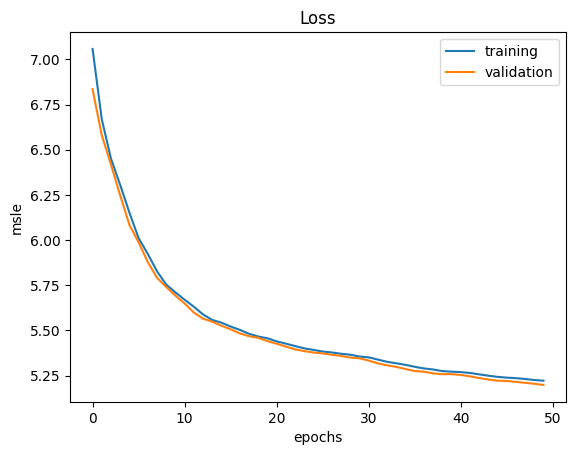

In [ ]:
plt.plot(avg_training, label='training')
plt.plot(avg_val, label='validation')

plt.plot(avg_val = np.mean(val_losses, axis=0)
, label='validation')
plt.xlabel('epochs')
plt.ylabel('msle')
plt.title('Loss')
plt.legend()
plt.show()